In [1]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [2]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

In [3]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    'rating',
    'startYear',
    # 'canHaveEpisodes',
    'runtimeMinutes_notitletype',
    'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western',
    'is_Music', 
    # 'is_Film-Noir',
    'is_Adult',
    'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime',
    # 'is_Short',
    'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    'is_Sport', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    'countryOfOrigin_OC',
    'countryOfOrigin_SA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_UNK',
    'criticReviewsTotal', 'userReviewsTotal',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
]

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform


# Prepare the data
X_train = train.loc[~train['outlier_no_type'], feats]
y_train = train.loc[~train['outlier_no_type'], 'titleType']

X_test = test.loc[~test['outlier_no_type'], feats]
y_test = test.loc[~test['outlier_no_type'], 'titleType']

# Scale the features


# Define the model
dt = DecisionTreeClassifier(random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1,50),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': [None, 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=500,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the model on the training set
y_train_pred = random_search.best_estimator_.predict(X_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'criterion': 'entropy', 'max_depth': 34, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 18, 'splitter': 'best'}
Best Score: 0.7693094791133985
Train Set Classification Report:
              precision    recall  f1-score   support

       movie       0.89      0.93      0.91      5442
       short       0.90      0.94      0.92      2382
   tvEpisode       0.89      0.94      0.91      4690
tvMiniSeries       0.49      0.25      0.33       186
     tvMovie       0.64      0.48      0.55       844
    tvSeries       0.77      0.74      0.76      1337
   tvSpecial       0.51      0.26      0.34       158
       video       0.76      0.53      0.63       744

    accuracy                           0.86     15783
   macro avg       0.73      0.63      0.67     15783
weighted avg       0.85      0.86      0.86     15783

Test Set Classification Report:
              precision    recall  f1-score   support

       movie       0.84      0.87      0.86      

In [6]:
random_search.best_estimator_.feature_importances_

array([1.25438034e-01, 3.48426772e-02, 7.35360958e-02, 2.01363040e-02,
       2.50928777e-02, 8.57082665e-02, 4.37661708e-01, 8.82464499e-03,
       3.76767924e-04, 1.02714912e-02, 1.12723011e-04, 2.86774188e-04,
       9.20110459e-03, 1.49000321e-04, 3.19183524e-04, 4.92868043e-04,
       3.25375891e-03, 2.26753101e-02, 7.08991142e-04, 0.00000000e+00,
       2.91799458e-03, 3.44453933e-03, 1.46973443e-03, 2.36052105e-03,
       9.84600640e-04, 1.56509710e-03, 9.32128821e-03, 8.04508133e-04,
       6.38912617e-04, 1.24878233e-02, 5.95267408e-02, 2.77535363e-03,
       1.39432716e-02, 3.26234606e-03, 6.29072895e-04, 0.00000000e+00,
       2.88818184e-03, 1.21761628e-02, 9.71527046e-03])

In [7]:
train.loc[train['countryOfOrigin_AF'] >= 1]

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno,totalNominations,totalMedia,runtimeMinutes_notitletype,outlier_no_type,outlier_w_type
124,El Banat Ayza Eih,6,1980,1980.0,NaN,0.0,95,3,0,19,...,0,0,0,0,86.0,0.0,3,62.0,False,False
142,Hokm al kawi,8,1951,1951.0,103.0,0.0,21,2,0,10,...,0,0,0,0,103.0,0.0,2,103.0,False,False
293,Al Shaweesh Hassan,4,1988,1988.0,100.0,0.0,11,1,0,11,...,0,0,0,0,100.0,0.0,1,100.0,False,False
615,Captain Gallant of the Foreign Legion,8,1955,NaN,30.0,0.0,118,14,0,119,...,1,0,0,0,30.0,0.0,14,30.0,False,False
675,Hayat azeb,6,1963,1963.0,87.0,0.0,26,1,0,18,...,0,0,0,0,87.0,0.0,1,87.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,The Exchange: Six Faces of the Gambia,6,2009,2009.0,23.0,0.0,8,0,0,6,...,0,0,0,0,23.0,0.0,0,23.0,False,False
15992,Ace of Hearts: Bwana Y'umutima,9,2017,2017.0,120.0,0.0,13,2,0,18,...,0,0,0,0,120.0,0.0,2,120.0,False,False
16015,Soultan,7,1958,1958.0,115.0,0.0,53,1,0,16,...,0,0,0,0,115.0,0.0,1,115.0,False,False
16027,Afrobeats: From Nigeria to the World,7,2017,2017.0,52.0,0.0,14,1,0,9,...,1,0,0,0,52.0,0.0,1,52.0,False,True


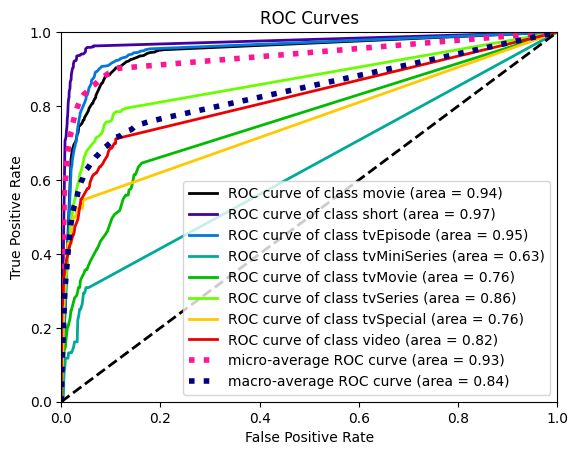

In [8]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

plot_roc(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

In [9]:
y_test

0              video
1              movie
2          tvSpecial
3          tvEpisode
4          tvEpisode
            ...     
5363           video
5364       tvEpisode
5365           movie
5366        tvSeries
5367    tvMiniSeries
Name: titleType, Length: 5246, dtype: object

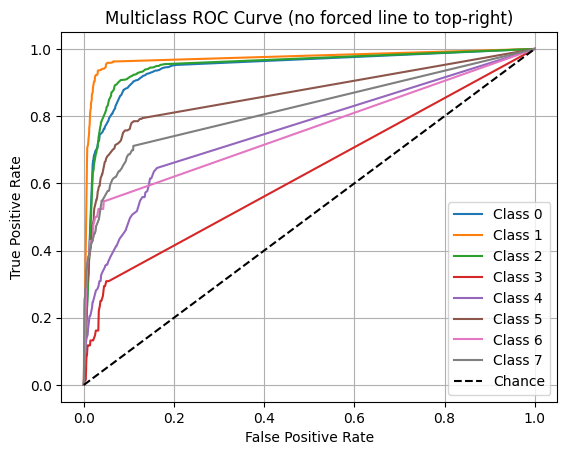

In [10]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities once, not inside the loop
proba = random_search.best_estimator_.predict_proba(X_test)

# Determine number of classes
n_classes = proba.shape[1]

# Binarize the true labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

y_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (no forced line to top-right)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


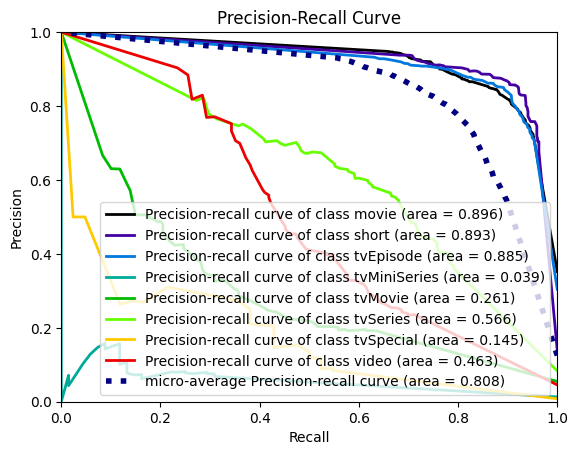

In [11]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

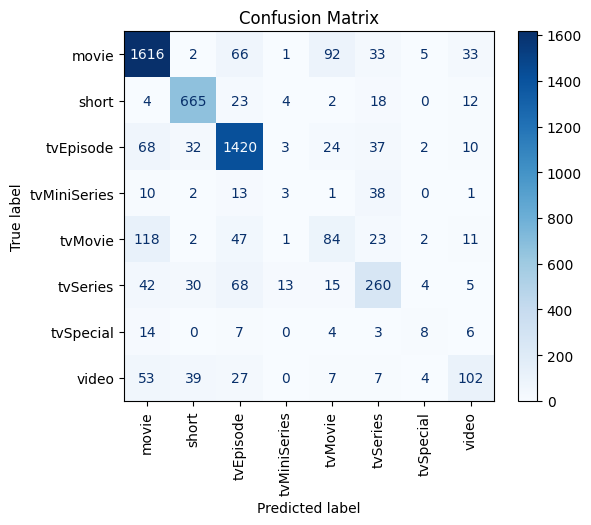

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = random_search.best_estimator_.classes_

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

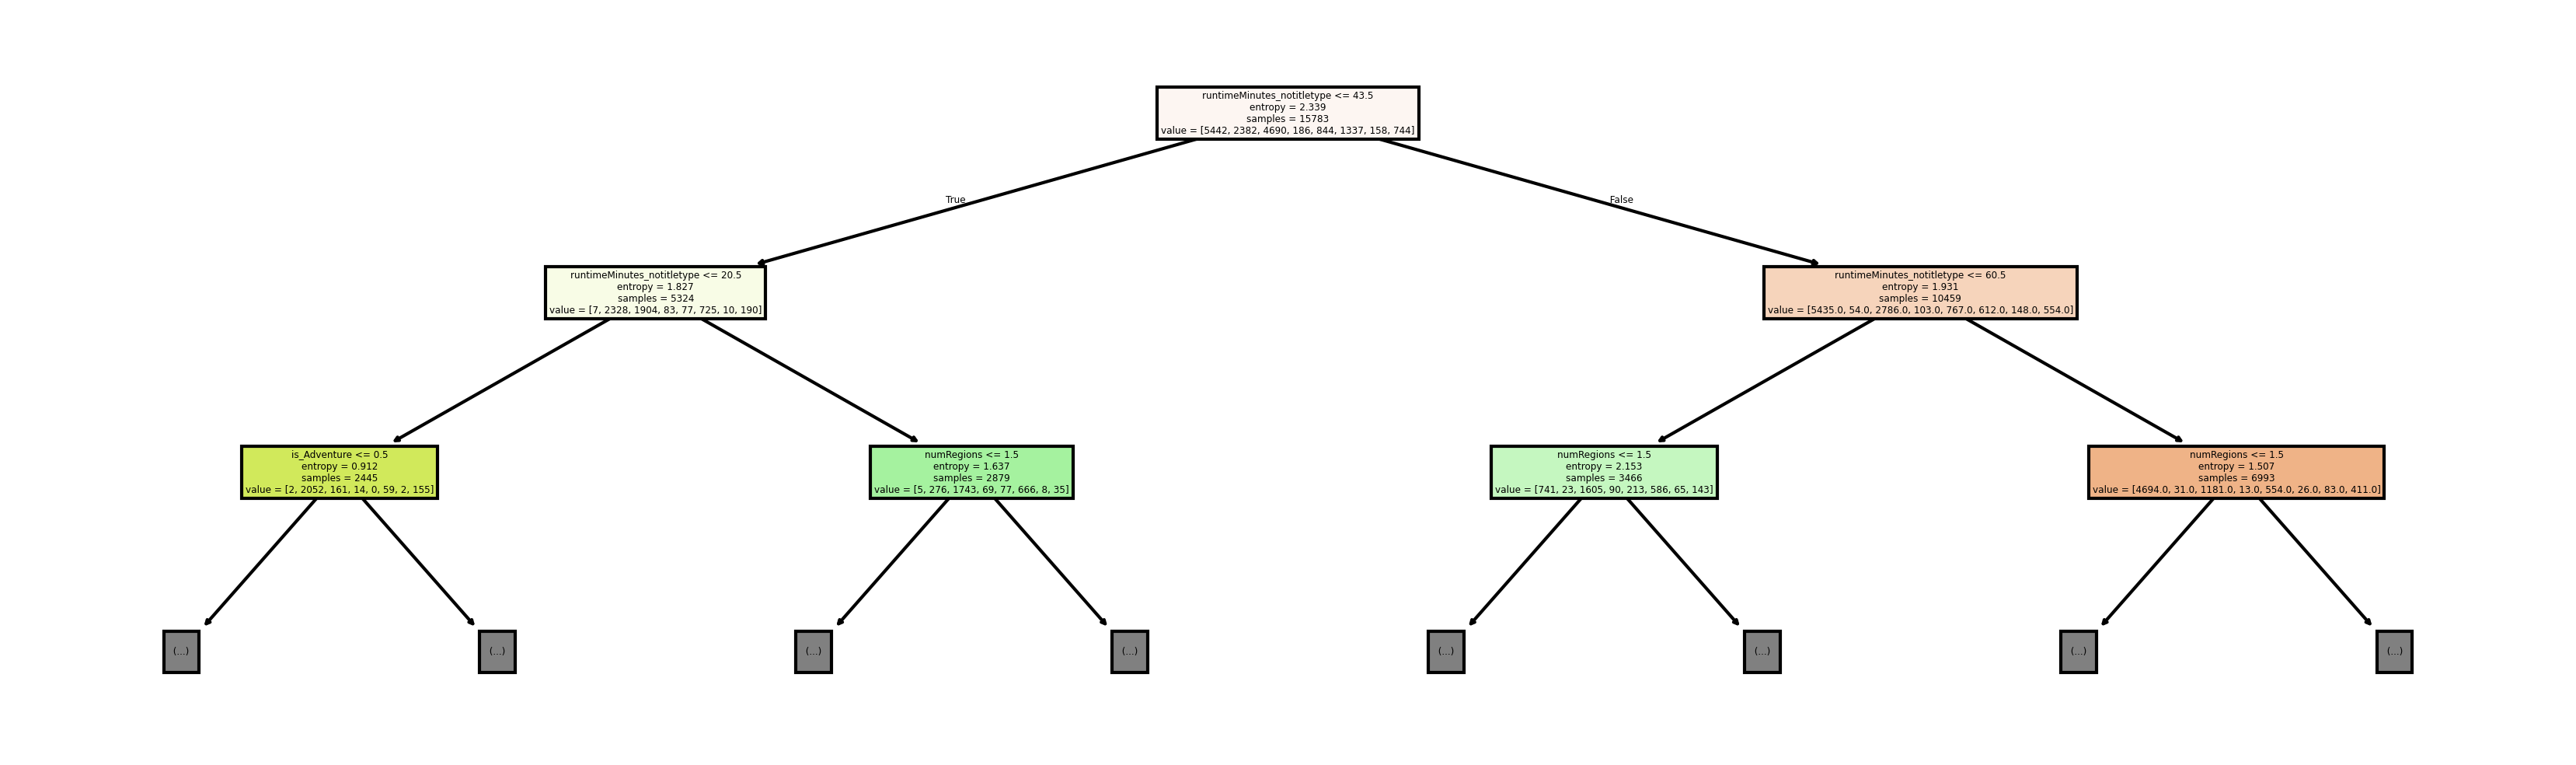

In [13]:
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 4), dpi=300)
plot_tree(random_search.best_estimator_, feature_names=feats, filled=True, max_depth=2)
plt.show()